**대회 목적:**

경쟁 데이터 세트에는 공개 도메인의 으스스한 작가가 쓴 소설의 텍스트가 포함되어 있습니다.
  1. 에드거 앨런 포(EAP)
  2. HP 러브크래프트(HPL)
  3. 메리 울스턴크래프트 셸리(MWS)
 
목표는 테스트 세트에서 문장의 저자를 정확하게 식별하는 것입니다.

**노트북의 목적:**

이 노트북에서 무시무시한 작성자를 식별하는 데 도움이 되는 다양한 기능을 만들어 보겠습니다.

첫 번째 단계로 기능 엔지니어링 부분을 자세히 살펴보기 전에 몇 가지 기본 데이터 시각화 및 정리를 수행합니다.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string # 문자/숫자의 리스트 출력

import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [2]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


각 저자의 출현 횟수를 확인하여 클래스가 균형을 이루고 있는지 확인할 수 있습니다.

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


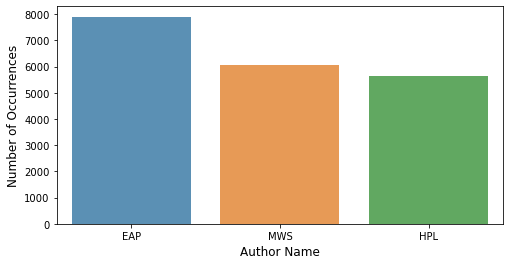

In [4]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

이것은 좋아 보인다. 계급 불균형이 별로 없다. 가능하면 각 저자의 글 스타일을 이해하고 이해하기 위해 각 저자의 몇 줄을 인쇄해 보겠습니다.

In [5]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

내가 볼 수있는 유일한 것은 텍스트 데이터에 상당히 많은 특수 문자가 있다는 것입니다. 따라서 이러한 특수 문자의 수는 좋은 변수일 수 있습니다. 아마 나중에 만들 수 있을 것입니다.

그 외에는 실마리가 별로 없습니다.. 재미있는 스타일(만들 수 있는 변수)이 있으면 댓글에 추가해 주세요.

**변수 엔지니어링:**

이제 변수 엔지니어링을 시도해 보겠습니다. 이것은 두 가지 주요 부분으로 구성됩니다.

 1. 메타 변수 - 단어 수, 중지 단어 수, 구두점 수 등과 같은 텍스트에서 추출된 변수
 2. 텍스트 기반 변수 - 빈도, svd, word2vec 등과 같은 텍스트/단어를 직접 기반으로 하는 변수

**메타 변수:**

우리는 메타 변수을 만드는 것부터 시작하여 그들이 으스스한 작가를 얼마나 잘 예측하는지 볼 것입니다. 변수 목록은 다음과 같습니다.
1. 텍스트의 단어 수
2. 텍스트의 고유 단어 수
3. 텍스트의 문자 수
4. 불용어의 수
5. 구두점 수
6. 대문자 단어의 수
7. 제목 케이스 단어의 수
8. 단어의 평균 길이

In [6]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

이제 예측에 도움이 될 몇 가지 새로운 변수를 플로팅해 보겠습니다.

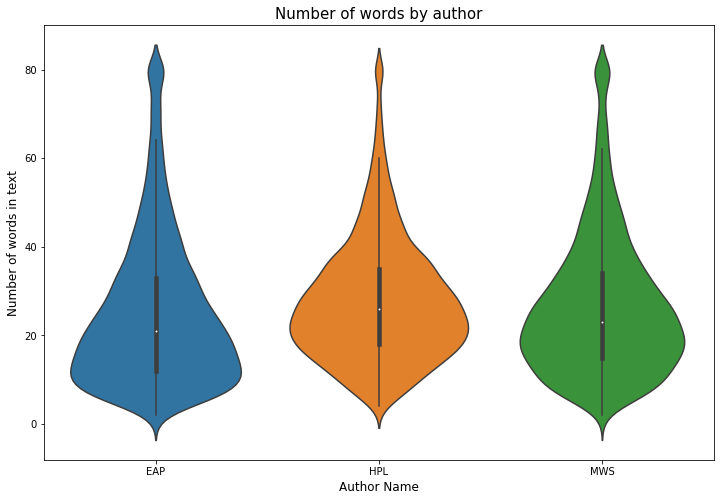

In [7]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

EAP는 MWS 및 HPL보다 단어 수가 약간 적은 것 같습니다.

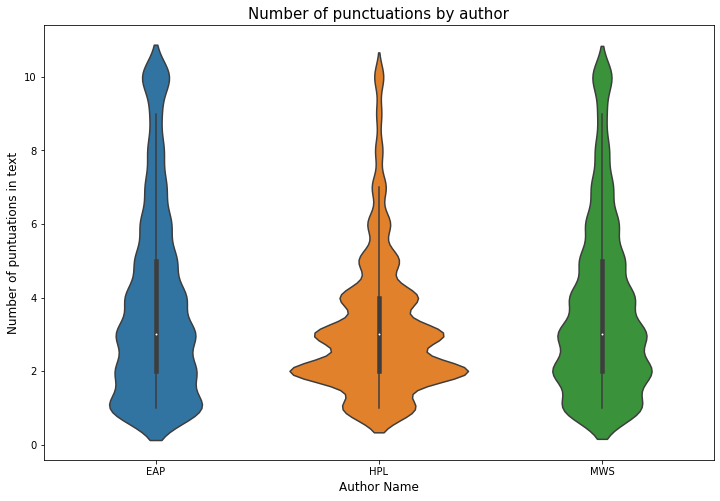

In [8]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

이것도 좀 쓸만해 보입니다. 이제 몇 가지 텍스트 기반 기능을 만드는 데 집중해 보겠습니다.

이러한 메타 변수가 어떻게 도움이 되는지 알아보기 위해 먼저 기본 모델을 구축해 보겠습니다.

In [9]:
train_df

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481
...,...,...,...,...,...,...,...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,20,19,108,11,3,2,2,4.450000
19575,id08973,The lids clenched themselves together as if in...,EAP,10,10,55,6,1,0,1,4.600000
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,13,13,68,4,2,0,2,4.307692
19577,id17513,"For an item of news like this, it strikes us i...",EAP,15,14,74,7,3,0,1,4.000000


In [10]:
## Prepare the data for modeling ###
# 라벨인코딩
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)

train_id = train_df['id'].values
test_id = test_df['id'].values

### 재작성 
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# 변수제거
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

이러한 메타 변수만으로 간단한 XGBoost 모델을 훈련할 수 있습니다.

In [17]:
dev_X

<15664x550841 sparse matrix of type '<class 'numpy.float64'>'
	with 487017 stored elements in Compressed Sparse Row format>

In [11]:
# runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    # 매개변수
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    # 희소행렬 -> DMatrix으로 변환
    # xgb.DMatrix -> xgb.train -> xgb.train.predict -> xgb.plot_importance
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

커널 실행 시간을 위해 점수에 대한 k-폴드 교차 검증의 첫 번째 폴드만 확인할 수 있습니다. 로컬에서 실행하는 동안 'break' 줄을 제거하십시오.

In [12]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[19:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.09384	test-mlogloss:1.09472
[20]	train-mlogloss:1.04663	test-mlogloss:1.05720
[40]	train-mlogloss:1.02368	test-mlogloss:1.03845
[60]	train-mlogloss:1.01109	test-mlogloss:1.02949
[80]	train-mlogloss:0.99824	test-mlogloss:1.01957
[100]	train-mlogloss:0.98938	test-mlogloss:1.01345
[120]	train-mlogloss:0.98209	test-mlogloss:1.00860
[140]	train-mlogloss:0.97603	test-mlogloss:1.00505
[160]	train-mlogloss:0.97088	test-mlogloss:1.00237
[180]	train-mlogloss:0.96619	test-mlogloss:1.00040
[200]	train-mlogloss:0.96141	test-mlogloss:0.99788
[220]	train-mlogloss:0.95745	t

C:\Users\HOME\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


메타 변수만 사용하여 '0.987'의 mlogloss를 얻고 있습니다. 나쁘지 않은 점수입니다. 이제 이러한 기능 중 어떤 것이 중요한지 살펴보겠습니다.

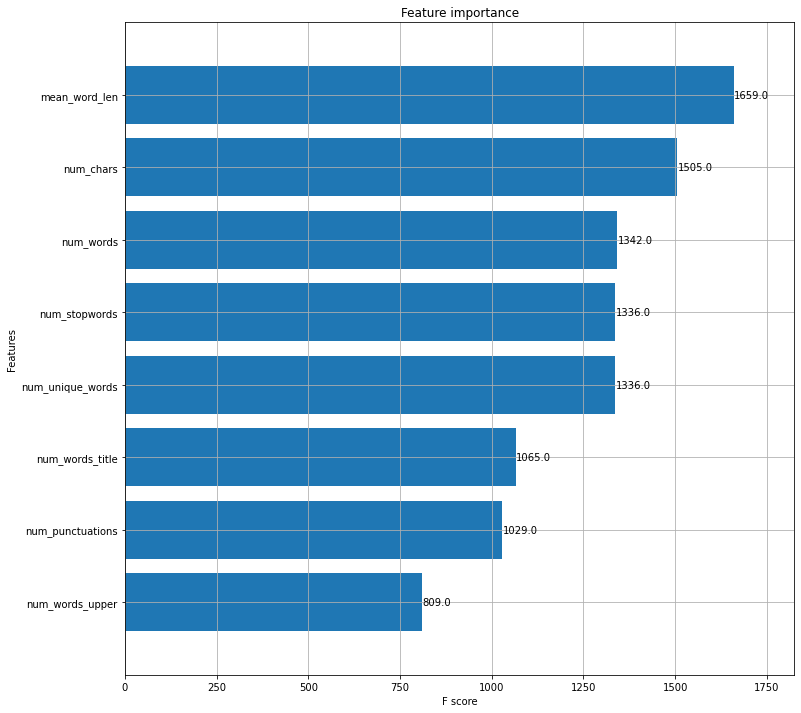

In [13]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

문자 수, 평균 단어 길이 및 고유 단어 수가 상위 3개 변수인 것으로 나타났습니다. 이제 몇 가지 텍스트 기반 변수를 만드는 데 집중해 보겠습니다.

**텍스트 기반 변수 :**

우리가 만들 수 있는 기본 기능 중 하나는 텍스트에 있는 단어의 tf-idf 값입니다. 그래서 우리는 그것으로 시작할 수 있습니다.

In [14]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))

full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 tfidf 벡터를 얻었으므로 여기에 까다로운 부분이 있습니다. 
tfidf 출력은 희소 행렬이므로 다른 밀집변수와 함께 사용해야 하는 경우 몇 가지 선택 사항이 있습니다.

1. 우리는 tfidf 벡터라이저에서 상위 'n' 변수(시스템 구성에 따라 다름)을 가져오도록 선택할 수 있으며, 이를 고밀도 형식으로 변환하고 다른 변수와 연결합니다.
2. 희소 특성만을 사용하여 모델을 만든 다음 다른 밀집변수와 함께 변수 중 하나로 예측을 사용합니다.

데이터 세트를 기반으로 하면 하나가 다른 것보다 더 잘 수행될 수 있습니다. 
여기에서는 tfidf의 모든 기능을 사용하는 매우 [좋은 점수 커널](https://www.kaggle.com/the1owl/python-tell-tale-tutorial)이 있으므로 두 번째 접근 방식을 사용할 수 있습니다.

또한 이 데이터 세트에서 [Naive Bayes가 더 나은 성능을 보입니다](https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399). 
따라서 훈련 속도가 더 빠르기 때문에 tfidf 기능을 사용하여 나이브베이즈 모델을 구축할 수 있습니다.

In [15]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

**Naive Bayes on Word Tfidf Vectorizer:**

In [16]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612855


우리는 tfidf vectorizer를 사용하여 0.844의 mlogloss를 얻고 있습니다. 메타 변수보다 훨씬 좋습니다. 혼동 행렬을 살펴보겠습니다.

In [18]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

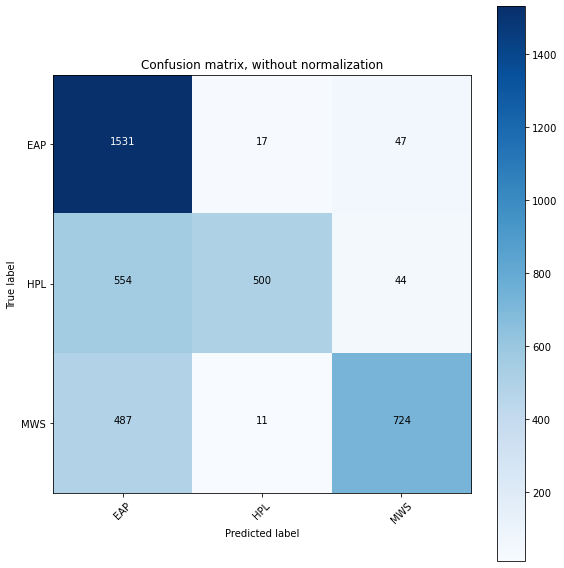

In [19]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()


많은 인스턴스가 EAP로 예측되고 해당 클래스에 크게 치우쳐 있습니다.

**단어 TFIDF의 SVD:**

tfidf 벡터는 희소하기 때문에 정보를 압축하고 훨씬 간결하게 표현하는 또 다른 방법은 SVD를 사용하는 것입니다. 또한 일반적으로 SVD 기능은 과거 텍스트 기반 대회에서 저에게 잘 수행되었습니다. 그래서 우리는 tfidf라는 단어에 svd 기능을 만들어 기능 세트에 추가할 수 있었습니다.

In [20]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**Naive Bayes on Word Count Vectorizer:**

In [21]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 count vectorizer 기반 기능을 사용하여 다항식 NB 모델을 구축해 보겠습니다.

In [22]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567435


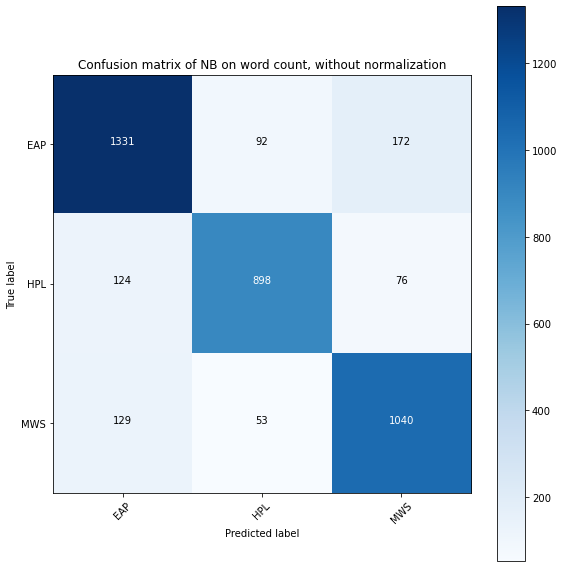

In [23]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

우와. tfidf vectorizer 대신 count vectorizer를 사용하여 0.451의 교차 검증 mlogloss를 얻었습니다. 이 모델을 사용한 LB 점수는 0.468입니다. 또한 혼동 행렬은 이전 것보다 훨씬 좋아 보입니다.

** Character Count Vectorizer의 Naive Bayes:**

"데이터 아이볼링"의 한 가지 아이디어는 특수 문자를 계산하는 것이 도움이 될 수 있다는 것입니다. 특수 문자를 계산하는 대신 문자 수준에서 count vectorizer를 사용하여 일부 기능을 얻을 수 있습니다. 다시 다항식 NB를 실행할 수 있습니다.

In [24]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


교차검증점수는 매우 높고 3.75입니다. 
그러나 이것은 단어 수준 변수와 다른 정보를 추가할 수 있으므로 최종 모델에도 사용하겠습니다.

**Character Tfidf Vectorizer의 Naive Bayes:**

또한 문자 tfidf 벡터라이저에 대한 나이브 베이즈 예측을 얻도록 합시다.

In [23]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947


**캐릭터 TFIDF의 SVD:**

또한 캐릭터 tfidf 변수에 svd 기능을 생성하고 모델링에 사용할 수도 있습니다.

In [24]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**XGBoost 모델:**

이제 이러한 새 변수를 사용하여 xgboost 모델을 다시 실행하고 결과를 평가할 수 있습니다.

In [25]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00096	test-mlogloss:1.00107
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.409459	test-mlogloss:0.415304
[40]	train-mlogloss:0.34062	test-mlogloss:0.352774
[60]	train-mlogloss:0.316677	test-mlogloss:0.335778
[80]	train-mlogloss:0.300345	test-mlogloss:0.326262
[100]	train-mlogloss:0.287444	test-mlogloss:0.320178
[120]	train-mlogloss:0.275705	test-mlogloss:0.3153
[140]	train-mlogloss:0.266531	test-mlogloss:0.311605
[160]	train-mlogloss:0.258131	test-mlogloss:0.310238
[180]	train-mlogloss:0.25033	test-mlogloss:0.308525
[200]	train-mlogloss:0.242455	test-mlogloss:0.307652
[220]	train-mlogloss:0.235288	test-mlogloss:0.306711
[240]	train-mlogloss:0.228882	test-mlogloss:0.306166
[260]	train-mlogloss:0.2227	test-mlogloss:0.305594
[280]	train-mlogloss:0.216774	test-mlogloss:0.305809
[300]	train-mlogloss:0.211088	test-mlogloss:0.305611
Stopping. Best 

**이것은 0.3055의 val 점수와 0.32xx의 LB 점수를 가지고 있습니다** 모든 폴드에서 실행하면 더 나은 점수를 얻을 수 있습니다. 이제 중요한 변수를 다시 확인해보자.

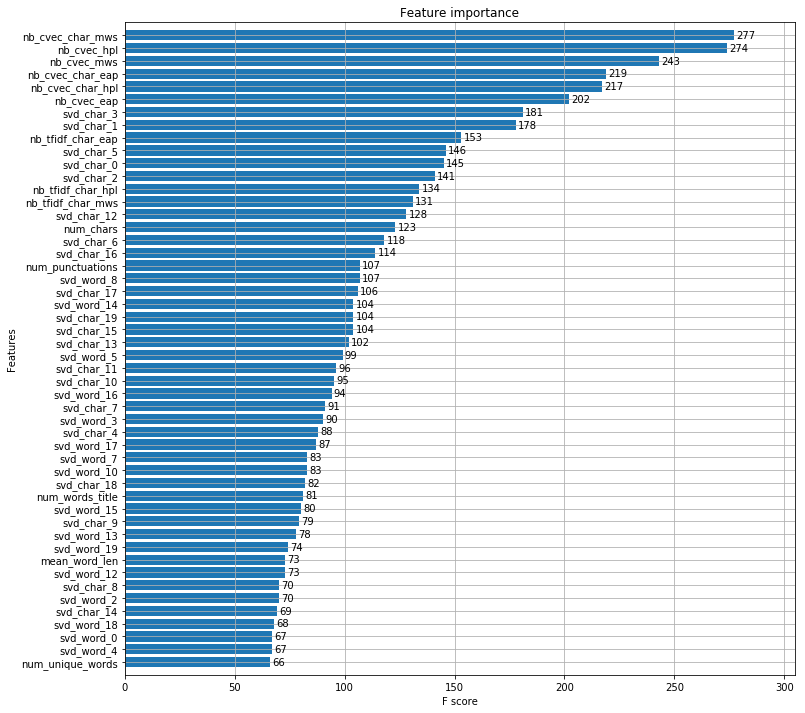

In [26]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Naive Bayes 변수는 예상대로 최고의 변수입니다. 이제 오분류 오류를 확인하기 위해 정오분류표를 구해 보겠습니다.

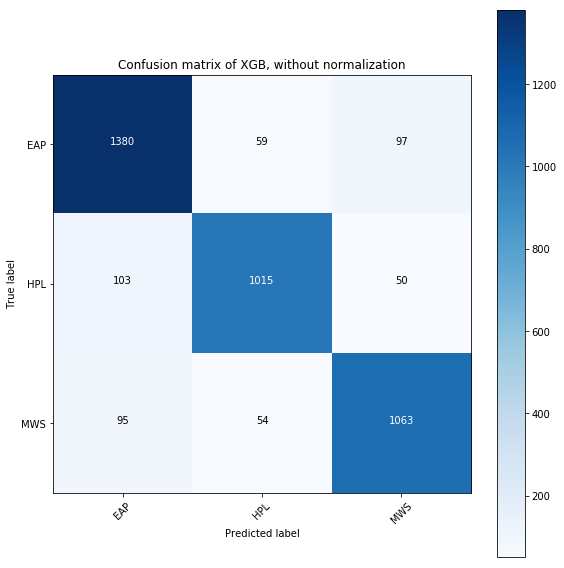

In [27]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

EAP와 MWS는 다른 것보다 더 자주 잘못 분류되는 것 같습니다. 이 쌍에 대한 예측을 개선하는 기능을 잠재적으로 생성할 수 있습니다.

**이 FE 노트북의 다음 단계:**
* 단어 임베딩 기반 기능 사용
* 기타 메타 기능이 있는 경우
* 문장에 대한 감상

**추가 개선을 위한 아이디어:**
* tfidf 및 카운트 벡터라이저에 대한 매개변수 조정
* 나이브 베이즈 및 XGB 모델에 대한 매개변수 조정
* 다른 모델과의 앙상블/스태킹

In [28]:
import af

ModuleNotFoundError: No module named 'af'

In [29]:

**More to come. Stay tuned.!**

SyntaxError: invalid syntax (<ipython-input-29-c7ace928696d>, line 2)